In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import timm  

In [17]:
DATA_PATH = '/kaggle/input/dog-breed-identification'
IMG_SIZE = 448  
BATCH_SIZE = 8  
EPOCHS = 15
LEARNING_RATE = 2e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [18]:
# Подготовка
labels_df = pd.read_csv(f'{DATA_PATH}/labels.csv')
le = LabelEncoder()
labels_df['breed_encoded'] = le.fit_transform(labels_df['breed'])
num_classes = len(le.classes_)

class DogDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['breed_encoded']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [19]:
# Аугментация данных
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
# Разделение данных
train_df, val_df = train_test_split(
    labels_df, 
    test_size=0.2, 
    stratify=labels_df['breed'],
    random_state=42
)

train_dataset = DogDataset(
    train_df, 
    img_dir=f'{DATA_PATH}/train', 
    transform=train_transform
)

val_dataset = DogDataset(
    val_df, 
    img_dir=f'{DATA_PATH}/train', 
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

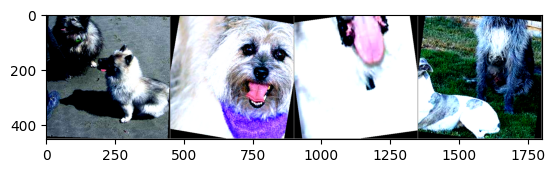

In [22]:
dog_classes = list(labels_df['breed'].unique())

dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:4]))

In [23]:
import timm
import torch.nn as nn

def create_model(num_classes):
    model = timm.create_model(
        'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k',
        pretrained=True,
        num_classes=0, 
        img_size=IMG_SIZE
    )
    
    for param in model.parameters():
        param.requires_grad = False
        
    for block in model.blocks[-6:]:  
        for param in block.parameters():
            param.requires_grad = True
    
    head = nn.Sequential(
        nn.LayerNorm(model.num_features),
        nn.Linear(model.num_features, 1024),
        nn.GELU(),
        nn.Dropout(0.4),
        nn.Linear(1024, num_classes))
    
    full_model = nn.Sequential(model, head)
    return full_model

num_classes = len(le.classes_)
model = create_model(num_classes).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params/1e9:.2f}B")
print(f"Trainable parameters: {trainable_params/1e6:.2f}M")

Total parameters: 0.31B
Trainable parameters: 76.77M


In [24]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in tqdm(loader, desc="Testing", leave=False):
        data, target = data.to(DEVICE), target.to(DEVICE)

        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()

        output = model(data)
        loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    best_val_loss = float('inf') 

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_loss.pth')
            print(f"Saved best model with val_loss: {val_loss:.4f}")
        
        if scheduler:
            scheduler.step(val_loss)
    
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

import torch.optim as optim
from timm.optim import AdamW
from timm.scheduler import CosineLRScheduler


optimizer = AdamW([
    {'params': model[0].parameters(), 'lr': 1e-5}, 
    {'params': model[1].parameters(), 'lr': 1e-4}   
], 
weight_decay=0.05,
betas=(0.9, 0.999)) 

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=EPOCHS,     
    lr_min=1e-6,          
    warmup_lr_init=1e-7,  
    warmup_t=5,           
    cycle_limit=1,        
    t_in_epochs=True      
)

history = train(
    model, 
    optimizer, 
    EPOCHS, 
    train_loader, 
    val_loader, 
    scheduler=scheduler
)


Epoch 1/15
Train Loss: 4.7785 | Train Acc: 0.0119
Val Loss: 4.7258 | Val Acc: 0.0181
Saved best model with val_loss: 4.7258



Epoch 2/15
Train Loss: 1.0423 | Train Acc: 0.8144
Val Loss: 0.2833 | Val Acc: 0.9219
Saved best model with val_loss: 0.2833



Epoch 3/15
Train Loss: 0.4488 | Train Acc: 0.8847
Val Loss: 0.2261 | Val Acc: 0.9409
Saved best model with val_loss: 0.2261



Epoch 4/15
Train Loss: 0.4335 | Train Acc: 0.8871
Val Loss: 0.2176 | Val Acc: 0.9399
Saved best model with val_loss: 0.2176



Epoch 5/15
Train Loss: 0.3920 | Train Acc: 0.8978
Val Loss: 0.2120 | Val Acc: 0.9419
Saved best model with val_loss: 0.2120



Epoch 6/15
Train Loss: 0.3911 | Train Acc: 0.8978
Val Loss: 0.2107 | Val Acc: 0.9424
Saved best model with val_loss: 0.2107



Epoch 7/15
Train Loss: 0.3849 | Train Acc: 0.8991
Val Loss: 0.2079 | Val Acc: 0.9419
Saved best model with val_loss: 0.2079



Epoch 8/15
Train Loss: 0.3974 | Train Acc: 0.8930
Val Loss: 0.2047 | Val Acc: 0.9409
Saved best model with val_loss: 0.2047



Epoch 9/15
Train Loss: 0.3717 | Train Acc: 0.9036
Val Loss: 0.2063 | Val Acc: 0.9429



Epoch 10/15
Train Loss: 0.3539 | Train Acc: 0.9055
Val Loss: 0.2052 | Val Acc: 0.9424



Epoch 11/15
Train Loss: 0.3368 | Train Acc: 0.9113
Val Loss: 0.2023 | Val Acc: 0.9453
Saved best model with val_loss: 0.2023



Epoch 12/15
Train Loss: 0.3451 | Train Acc: 0.9087
Val Loss: 0.2031 | Val Acc: 0.9429



Epoch 13/15
Train Loss: 0.3624 | Train Acc: 0.9030
Val Loss: 0.2030 | Val Acc: 0.9429



Epoch 14/15
Train Loss: 0.3643 | Train Acc: 0.9074
Val Loss: 0.2017 | Val Acc: 0.9443
Saved best model with val_loss: 0.2017



Epoch 15/15
Train Loss: 0.3420 | Train Acc: 0.9101
Val Loss: 0.2020 | Val Acc: 0.9429


In [25]:
# Создание предсказаний для submission
def create_submission(model, test_dir, transform, device, breed_names):
    test_files = os.listdir(test_dir)
    model.load_state_dict(torch.load('best_model_loss.pth'))
    model.eval()
    
    all_preds = []
    test_ids = []
    
    for file in tqdm(test_files, desc="Processing Test Images"):
        img_path = os.path.join(test_dir, file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            probas = F.softmax(output, dim=1).cpu().numpy()[0]
        
        all_preds.append(probas)
        test_ids.append(file.split('.')[0])
    
    submission = pd.DataFrame(
        np.vstack(all_preds),
        columns=breed_names
    )
    submission.insert(0, 'id', test_ids)
    return submission

# Генерация submission файла
test_dir = f'{DATA_PATH}/test'
breed_names = le.classes_
submission = create_submission(model, test_dir, val_transform, DEVICE, breed_names)
submission.to_csv('submission.csv', index=False)
print('Submission file created!')


Processing Test Images: 100%|██████████| 10357/10357 [26:23<00:00,  6.54it/s]


Submission file created!
